# NOTE
[0512 note]
*  use ALL camera devices to train Federated Model --> 4

*  D#5/6/8/9 local model and global model for evaluation

*  Adam // 1000 baseline_data // other device benign_tr:benign_test -> 0.8:0.2

[0519 note]
*  Add 'server_aggregate_M()' function for FedAvgM

*  'server_aggregate()' for FedAvg

[0520 note]

*  use D#568 for training FL, test on D#123479

[0528 note]

* train #12347, test #5689
* train #12345678, test #9

[0531 note]

* train #123456789

# Import Libraries/Packages & Datasets

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from collections import Counter
# from scipy import stats
# import os
import random
from tqdm import tqdm
# import logging
# import itertools
import time
# from collections import defaultdict
# from datetime import timedelta
import copy

from sklearn import preprocessing
# from sklearn.preprocessing import scale
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import recall_score, auc, roc_curve, confusion_matrix, classification_report, precision_recall_fscore_support, f1_score
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# from torchvision import datasets, transforms

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

In [6]:
# load data
d1 = pd.read_csv('/home/ubuntu/inf-retrieval/AD_FL_DL/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
d2 = pd.read_csv('/home/ubuntu/inf-retrieval/AD_FL_DL/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
d3 = pd.read_csv('/home/ubuntu/inf-retrieval/AD_FL_DL/Friday-WorkingHours-Morning.pcap_ISCX.csv')
d4 = pd.read_csv('/home/ubuntu/inf-retrieval/AD_FL_DL/Monday-WorkingHours.pcap_ISCX.csv')
d5 = pd.read_csv('/home/ubuntu/inf-retrieval/AD_FL_DL/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
d6 = pd.read_csv('/home/ubuntu/inf-retrieval/AD_FL_DL/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
d7 = pd.read_csv('/home/ubuntu/inf-retrieval/AD_FL_DL/Tuesday-WorkingHours.pcap_ISCX.csv')
d8 = pd.read_csv('/home/ubuntu/inf-retrieval/AD_FL_DL/Wednesday-workingHours.pcap_ISCX.csv')

d1.shape, d2.shape, d3.shape, d4.shape, d5.shape, d6.shape, d7.shape, d8.shape,

# load dataset for other types of devices here.....

((225745, 79),
 (286467, 79),
 (191033, 79),
 (529918, 79),
 (288602, 79),
 (170366, 79),
 (445909, 79),
 (692703, 79))

# Data Pre-processing

In [7]:
def pre_processing(data):
    data.columns = data.columns.str.strip()  # Removes leading/trailing spaces

    data = data.drop(data.columns[0], axis=1)

    benign = data[data['Label'] == 'BENIGN'] 
    benign = benign.drop('Label',axis=1)
    benign['Label'] = 0

    abnormal = data[data['Label'] != 'BENIGN']
    abnormal = abnormal.drop('Label',axis=1)
    abnormal['Label'] = 1

    # split benign data evenly to three parts
    benign_train, benign_tr, benign_test = np.split(benign, [int((1/3)*len(benign)), int((2/3)*len(benign))])
    benign_test_mix = benign_test.copy()    # with label 116

    benign_train = benign_train.fillna(benign_train.mean())
    benign_train.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
    benign_train = benign_train.dropna()  # 

    train_label = benign_train['Label']

    benign_train = benign_train.drop('Label',axis=1)
    benign_tr = benign_tr.drop('Label',axis=1)

    benign_tr = benign_tr.fillna(benign_train.mean())
    benign_tr.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
    benign_tr = benign_tr.dropna()  # 

    # Create Mix data
    abnormal_sample = abnormal.sample(frac = 1)              # use all abnormal data.  (frac = 0.1) -> select 10%
    mix_temp = pd.concat([benign_test_mix, abnormal_sample]) # concatenate
    mix_temp = shuffle(mix_temp, random_state=1)  

    mix = mix_temp.copy()                   # mix with label # 116
    mix_data = mix_temp.drop('Label',axis=1) # only data      # 115

    mix_data = mix_data.fillna(benign_train.mean())
    mix_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
    mix_data = mix_data.dropna()  # 
    
    mix_label = mix['Label']

    scaler = StandardScaler()
    benign_train = scaler.fit_transform(benign_train) # 115 all benign 
    benign_tr = scaler.transform(benign_tr)           # 115 all benign 
    mix_data = scaler.transform(mix_data)             # ([xxx, 115])

    # keep benign_train as original form here --> for later use
    benign_tr = torch.from_numpy(np.array(benign_tr)).float().to(device)    # 115  all benign --> for calculate threshold
    mix_data = torch.from_numpy(np.array(mix_data)).float().to(device)      # 115  benign + abnormal  --> for evaluation
    mix_label = torch.tensor(np.array(mix_label))

    return benign_train, benign_tr, mix_data, mix_label

In [ ]:
def other_pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['Label'] == 'BENIGN'] 
    benign = benign.drop('Label',axis = 1)
    benign['Label'] = 0

    abnormal = data[data['Label'] != 'BENIGN']
    abnormal = abnormal.drop('Label',axis = 1)
    abnormal['Label'] = 1

    # split benign data to two parts
    benign_tr, benign_test = train_test_split(benign, test_size = 0.2, random_state = 5703)
    benign_tr = benign_tr.drop('Label',axis=1)

    # Create Mix data
    abnormal_sample = abnormal.sample(frac = 1)           # 116  use all abnoraml, but can change to use part
    mix_temp = pd.concat([benign_test, abnormal_sample])  # 116
    mix_temp = shuffle(mix_temp, random_state=1)          # for test model

    mix = mix_temp.copy()                   # mix data with label # 116
    mix_data = mix_temp.drop('Label',axis=1) # no label # 115
    mix_label = mix['Label']

    # Replace inf/-inf with NaN
    benign_tr = benign_tr.replace([np.inf, -np.inf], np.nan)

    # Then fill NaN with mean or drop them
    benign_tr = benign_tr.fillna(benign_tr.mean())

    # Now safe to scale
    scaler = StandardScaler()
    benign_tr = scaler.fit_transform(benign_tr)

    # Apply same transformation to mix_data
    mix_data = mix_data.replace([np.inf, -np.inf], np.nan)
    mix_data = mix_data.fillna(mix_data.mean())
    mix_data = scaler.transform(mix_data)

    # Standardisation
    scaler = StandardScaler()
    benign_tr = scaler.fit_transform(benign_tr)        
    mix_data = scaler.transform(mix_data) 

    benign_tr = benign_tr.fillna(benign_tr.mean())
    benign_tr.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
    benign_tr = benign_tr.dropna()  # Then drop the rows with NaN

    benign_tr = torch.from_numpy(np.array(benign_tr)).float().to(device)  # 115  all benign --> for calculate threshold  # Fill NaN with the column mean
    mix_data = torch.from_numpy(np.array(mix_data)).float().to(device)    # 115  data -> benign + abnormal  --> for evaluation
    mix_label = torch.tensor(np.array(mix_label))                         # 0/1  label -> benign + abnormal  --> for evaluation

    return benign_tr, mix_data, mix_label

In [9]:
# for Federated Model training
benign_train_1, benign_tr_1, mix_data_1, mix_label_1 = pre_processing(d1)
benign_train_2, benign_tr_2, mix_data_2, mix_label_2 = pre_processing(d2)
benign_train_3, benign_tr_3, mix_data_3, mix_label_3 = pre_processing(d3)
benign_train_4, benign_tr_4, mix_data_4, mix_label_4 = pre_processing(d4)
benign_train_5, benign_tr_5, mix_data_5, mix_label_5 = pre_processing(d5)
benign_train_6, benign_tr_6, mix_data_6, mix_label_6 = pre_processing(d6)
benign_train_7, benign_tr_7, mix_data_7, mix_label_7 = pre_processing(d7)
benign_train_8, benign_tr_8, mix_data_8, mix_label_8 = pre_processing(d8)


/home/ubuntu/inf-retrieval/AD_FL_DL/myenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/ubuntu/inf-retrieval/AD_FL_DL/myenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/ubuntu/inf-retrieval/AD_FL_DL/myenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/ubuntu/inf-retrieval/AD_FL_DL/myenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use '

In [14]:
print(d1.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [14]:
# device for test federated model
benign_tr_1, mix_data_1, mix_label_1 = other_pre_processing(d1)
benign_tr_2, mix_data_2, mix_label_2 = other_pre_processing(d2)
benign_tr_3, mix_data_3, mix_label_3 = other_pre_processing(d3)
benign_tr_4, mix_data_4, mix_label_4 = other_pre_processing(d4)
benign_tr_5, mix_data_5, mix_label_5 = other_pre_processing(d5)
benign_tr_6, mix_data_6, mix_label_6 = other_pre_processing(d6)
benign_tr_7, mix_data_7, mix_label_7 = other_pre_processing(d7)
benign_tr_8, mix_data_8, mix_label_8 = other_pre_processing(d8)
# benign_tr_9, mix_data_9, mix_label_9 = other_pre_processing(d9)

ValueError: Input X contains infinity or a value too large for dtype('float64').

# Prepare for training

## Parameters Setting

In [ ]:
num_clients = 8      # Number of clients
num_selected = 3     # Typically, num_selected is around 30–40% of the num_clients.
batch_size = 78
baseline_num = 1000  # choose some data from the train set to retrain the data from trained model 
num_rounds = 3#100      # Total number of communication rounds for the global model to train.
epochs = 5          # for train client model
retrain_epochs = 5  # Total number of retraining rounds on the global server after receiving the model weights 
                      # from all the clients that participated in the communication round.

## Retraining Mechanism

In [49]:
# For retraining mechanism
# pick baseline_data for each device
def baseline_data(size = baseline_num, batch_size = batch_size): # baseline_num
    rng = np.random.default_rng()
    x_1 = rng.choice(benign_train_1, size=size, replace = True, shuffle = True, axis=0) # [[[[[[randomly select]]]]]] 
    x_2 = rng.choice(benign_train_2, size=size, replace = True, shuffle = True, axis=0)
    x_3 = rng.choice(benign_train_3, size=size, replace = True, shuffle = True, axis=0)
    x_4 = rng.choice(benign_train_4, size=size, replace = True, shuffle = True, axis=0)
    x_5 = rng.choice(benign_train_5, size=size, replace = True, shuffle = True, axis=0)
    x_6 = rng.choice(benign_train_6, size=size, replace = True, shuffle = True, axis=0)
    x_7 = rng.choice(benign_train_7, size=size, replace = True, shuffle = True, axis=0)
    x_8 = rng.choice(benign_train_8, size=size, replace = True, shuffle = True, axis=0)



    loader_1 = torch.utils.data.DataLoader(x_1, batch_size=batch_size)
    loader_2 = torch.utils.data.DataLoader(x_2, batch_size=batch_size)
    loader_3 = torch.utils.data.DataLoader(x_3, batch_size=batch_size)
    loader_4 = torch.utils.data.DataLoader(x_4, batch_size=batch_size)
    loader_5 = torch.utils.data.DataLoader(x_5, batch_size=batch_size)
    loader_6 = torch.utils.data.DataLoader(x_6, batch_size=batch_size)
    loader_7 = torch.utils.data.DataLoader(x_7, batch_size=batch_size)
    loader_8 = torch.utils.data.DataLoader(x_8, batch_size=batch_size)


    loaders = {'D1': loader_1,
               'D2': loader_2,
               'D3': loader_3,
               'D4': loader_4,
               'D5': loader_5,
               'D6': loader_6,
               'D7': loader_7,
               'D8': loader_8}

    return loaders

## FedAvg / FedAvgM

In [50]:
# aggregates the model weights received from every client 
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()): 
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias
        


## Utilities

In [51]:
# for main training process
# collect training data of each device
def train_data_loaders(batch_size = batch_size):
    data_1 = torch.utils.data.DataLoader(benign_train_1, batch_size = batch_size, shuffle=True)
    data_2 = torch.utils.data.DataLoader(benign_train_2, batch_size = batch_size, shuffle=True)
    data_3 = torch.utils.data.DataLoader(benign_train_3, batch_size = batch_size, shuffle=True)
    data_4 = torch.utils.data.DataLoader(benign_train_4, batch_size = batch_size, shuffle=True)
    data_5 = torch.utils.data.DataLoader(benign_train_5, batch_size = batch_size, shuffle=True)
    data_6 = torch.utils.data.DataLoader(benign_train_6, batch_size = batch_size, shuffle=True)
    data_7 = torch.utils.data.DataLoader(benign_train_7, batch_size = batch_size, shuffle=True)
    data_8 = torch.utils.data.DataLoader(benign_train_8, batch_size = batch_size, shuffle=True)

    client_loaders = {'D1': data_1,
                      'D2': data_2,
                      'D3': data_3,
                      'D4': data_4,
                      'D5': data_5,
                      'D6': data_6,
                      'D7': data_7,
                      'D8': data_8}

    return client_loaders

In [52]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for bx, (data) in enumerate(train_data):
            output = client_model(data.float()) # tensor 115
            optimizer.zero_grad()
            # criterion = nn.MSELoss(reduction='mean')
            # loss = criterion(data.to(device), output)
            loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
            loss.backward()
            optimizer.step()
            # print(loss.item())
            running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())


## Deep Auto-encoder Model

In [ ]:
# Deep Auto-encoder model

input_dim = 78
class AEModel(nn.Module):
    def __init__(self):
        super(AEModel,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(0.75*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75*input_dim), int(0.5*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5*input_dim), int(0.33*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33*input_dim), int(0.25*input_dim)),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(int(0.25*input_dim), int(0.33*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33*input_dim), int(0.5*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5*input_dim), int(0.75*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75*input_dim), int(input_dim)),
            nn.Tanh(),
        )
    def forward(self, x):
        encode = self.encoder(x)
        decoder = self.decoder(encode)
        return decoder

## Initialisation

In [55]:
# Initializing models and optimizer

global_model = AEModel().to(device)
client_models = [AEModel().to(device) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]

In [56]:
baseline_data = baseline_data() # size = 1000
train_loader = train_data_loaders() #batch_size=128
# devices = ['D5','D6','D8','D9']
# devices = ['D5','D6','D8']
# devices = ['D1','D2','D3','D4','D7']
devices = ['D1','D2','D3','D4','D5','D6','D7','D8']

# Training Federated Model

In [57]:
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    print('client_idx: ',client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] 
    # client_lens = [len(train_loader[idx]) for idx in client_idx ]
    # print(client_lens)


    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected)): 
        # print(i)
        client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        loss += client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
    train_loss_client.append(loss)


    #### retraining on the global server ####
    loss_retrain = 0
    for i in tqdm(range(num_selected)): 
        loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    train_loss_global.append(loss_retrain/num_selected)


    ### aggregate models ###
    # server_aggregate(global_model, client_models, client_lens)      # FedAvg
    server_aggregate_M(global_model, client_models, client_lens)    # FedAvgM

    print("\nclient_loss: ", loss)
    print('global_loss: ', loss_retrain/num_selected)

# save model
torch.save(global_model,'global.pt')

time_required = time.time() - start_time
print('\nTIME: {}mins'.format(time_required/60))


round:  1
client_idx:  [2 0 7]


100%|██████████| 3/3 [00:14<00:00,  4.98s/it]



client_loss:  1.793886009345873
global_loss:  1.324019879484788

round:  2
client_idx:  [0 6 5]


100%|██████████| 3/3 [00:17<00:00,  5.84s/it]



client_loss:  4.323817493780617
global_loss:  1.303869733443627

round:  3
client_idx:  [5 3 7]


100%|██████████| 3/3 [01:02<00:00, 20.76s/it]


client_loss:  4.455349904418958
global_loss:  2.2412080825903478

TIME: 200.69814513127008mins


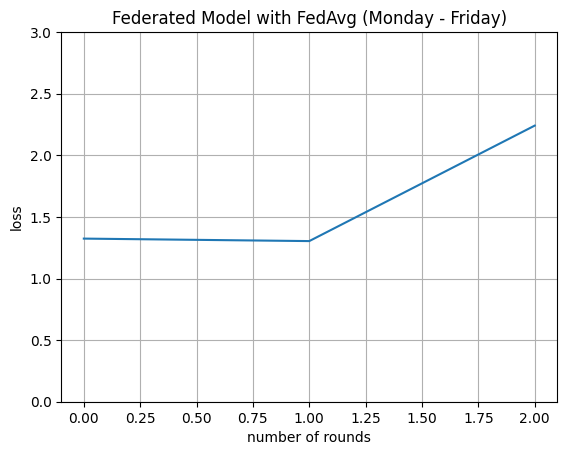

In [70]:
# train_loss_global
plt.plot(train_loss_global)
plt.xlabel('number of rounds')
plt.ylabel('loss')
plt.ylim((0, 3))
plt.grid()
plt.title('Federated Model with FedAvg (Monday - Friday)')
plt.show()

# Evaluation

In [129]:
def get_tr(model, tr_data):
    model.eval()
    mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    tr = 0.0025 * mse.mean() + 0.0025 * mse.std()
    return tr

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    mse = np.mean(np.power(mix_data.cpu().detach().numpy() - model(mix_data).cpu().detach().numpy(), 2), axis=1)

    prediction = []
    for i in mse:
        if i > tr:
            prediction.append(1)
        else:
            prediction.append(0)
    
    mix_label_list = mix_label.tolist()
    TP,FP,TN,FN = perf_measure(mix_label_list, prediction)
    conf = [[TP, FN],[FP, TN]]
    x_axis_label = ['abnormal', 'benign']
    y_axis_label = ['abnormal', 'benign']
    plt.figure()
    sns.heatmap(conf,xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16},fmt='g')

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6) 
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100, 
                                                                                                   precision, 
                                                                                                   recall, 
                                                                                                   F1score, 
                                                                                                   TPR, 
                                                                                                   FPR))
    



In [130]:
# load model
global_model = torch.load('global.pt', weights_only=False)

# Test on client devices

In [131]:
# Calculate TR
tr_1 = get_tr(global_model, benign_tr_1)
tr_2 = get_tr(global_model, benign_tr_2)
tr_3 = get_tr(global_model, benign_tr_3)
tr_4 = get_tr(global_model, benign_tr_4)
tr_5 = get_tr(global_model, benign_tr_5)
tr_6 = get_tr(global_model, benign_tr_6)
tr_7 = get_tr(global_model, benign_tr_7)
tr_8 = get_tr(global_model, benign_tr_8)

D1: 
Acc: 79.719% 
Precision: 0.797 
Recall: 1.000 
F1score: 0.887 
TPR: 1.00000 
FPR: 1.00000

D2: 
Acc: 78.892% 
Precision: 0.789 
Recall: 1.000 
F1score: 0.882 
TPR: 1.00000 
FPR: 1.00000

D3: 
Acc: 3.025% 
Precision: 0.030 
Recall: 1.000 
F1score: 0.059 
TPR: 1.00000 
FPR: 1.00000

D4: 


ZeroDivisionError: division by zero

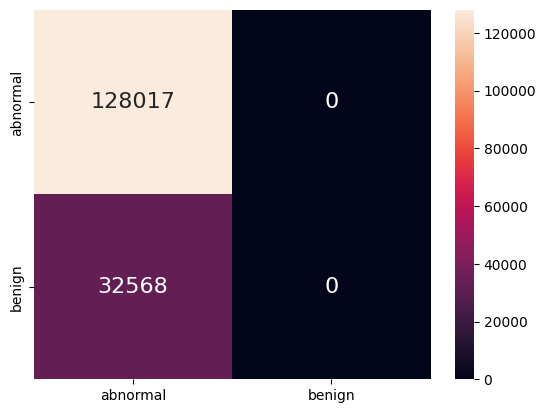

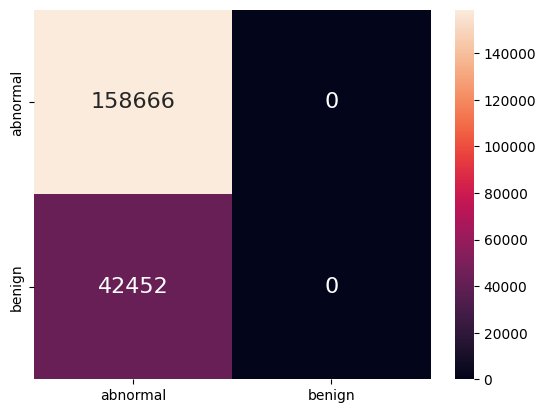

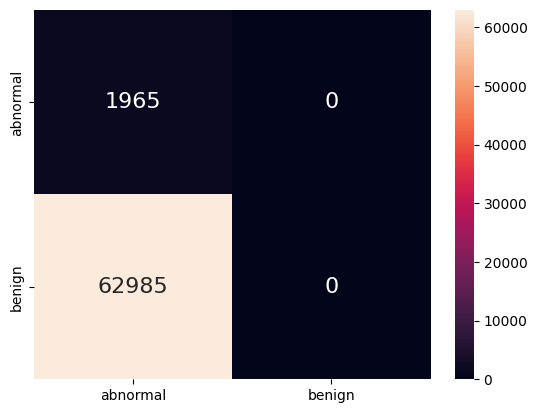

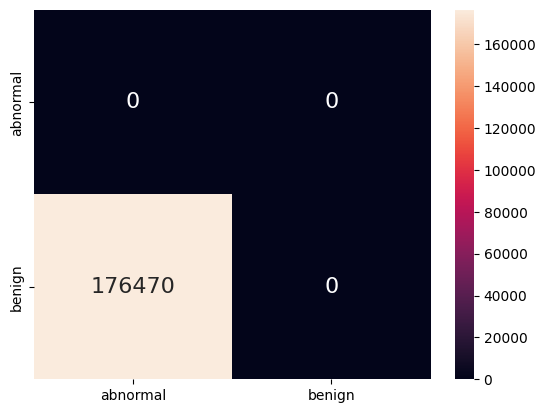

In [ ]:
# use global model & device's TR
print("D1: ")
get_mix_result(global_model, tr_1, mix_data_1, mix_label_1)
print('\nD2: ')
get_mix_result(global_model, tr_2, mix_data_2, mix_label_2)
print("\nD3: ")
get_mix_result(global_model, tr_3, mix_data_3, mix_label_3)
# print('\nD4: ')
# get_mix_result(global_model, tr_4, mix_data_4, mix_label_4)


D6: 
Acc: 3.744% 
Precision: 0.037 
Recall: 1.000 
F1score: 0.072 
TPR: 1.00000 
FPR: 1.00000

D7: 
Acc: 8.765% 
Precision: 0.088 
Recall: 1.000 
F1score: 0.161 
TPR: 1.00000 
FPR: 1.00000

D8: 
Acc: 63.274% 
Precision: 0.633 
Recall: 1.000 
F1score: 0.775 
TPR: 1.00000 
FPR: 1.00000


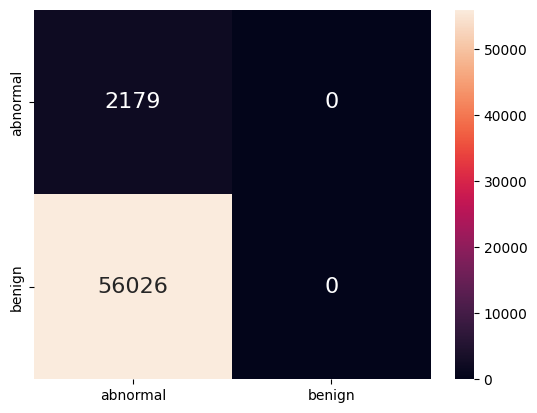

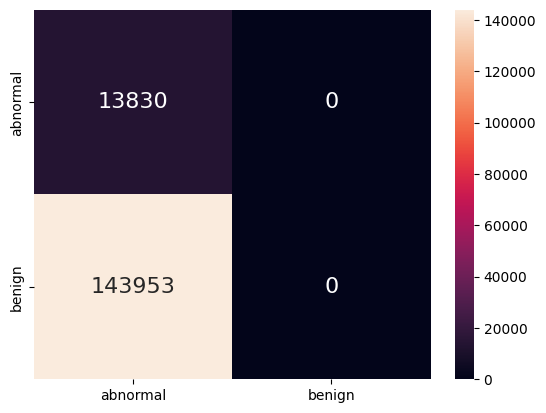

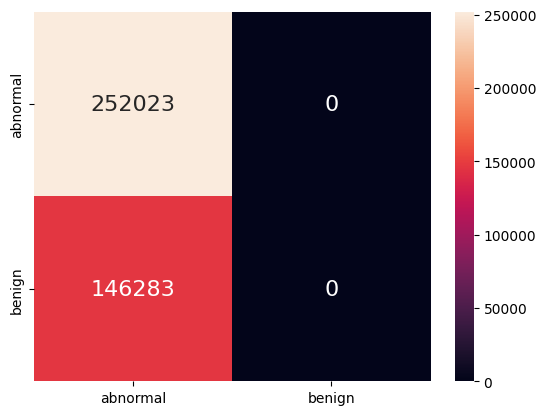

In [133]:
# print("D5: ")
# get_mix_result(global_model, tr_5, mix_data_5, mix_label_5)
print('\nD6: ')
get_mix_result(global_model, tr_6, mix_data_6, mix_label_6)
print('\nD7: ')
get_mix_result(global_model, tr_7, mix_data_7, mix_label_7)
print("\nD8: ")
get_mix_result(global_model, tr_8, mix_data_8, mix_label_8)

# Test on other devices